# Bibliotheken und Funktionen Importieren

In [203]:
# Bibliotheken importieren
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Daten einlesen und Organisieren

In [204]:
# Daten laden
df = pd.read_csv('../../Data_Processing/whole_cleaned_dataset.csv')

# Features und Zielspalte
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Stratified Folds Erstellen

In [205]:
# Stratified K-Fold einrichten
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Parameter für Grid Search


In [206]:
param_grid = {
    #'C':      [0.01, 0.1, 1, 10, 100],   # Best Result = 1
    #'C':    [0.8, 0.9, 1, 1.1, 1,2],     # Best Result = 0.8
    #'C':    [0.5, 0.6, 0.7, 0.8, 0.9],  # Best Result = 0.8
    'C':    [0.75, 0.775, 0.8, 0.825, 0.85],    # Best Result = 0.825
    'penalty':['l1', 'l2'],
    'solver': ['liblinear'],  # liblinear unterstützt l1 und l2
}


# GridSearchCV mit AUC als Optimierungsziel
grid = GridSearchCV(
    estimator = LogisticRegression(class_weight='balanced', max_iter=1000),
    param_grid = param_grid,
    cv         = skf,
    scoring    = 'roc_auc',
    n_jobs     = -1,        # alle CPUs nutzen
    verbose    = 1
)


# Hyperparameter Tuning

In [207]:
# Grid Search durchführen
grid.fit(X, y)
# Resultate zurückgeben
print("Best Parameters: ", grid.best_params_)
print("Best Mean AUC:   ", grid.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters:  {'C': 0.775, 'penalty': 'l1', 'solver': 'liblinear'}
Best Mean AUC:    0.8428728162124388


# Best Hyperparameter Model auswählen

In [208]:
best_model = grid.best_estimator_


# Metriken Listen 

In [209]:
# Metriken speichern
precision_list = []
recall_list = []
f1_list = []
auc_list = []

mean_fpr = np.linspace(0, 1, 100)
tprs = []
conf_matrices = []

# Cross Valiation 

In [210]:
# Cross-Validation Schleife
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #model = LogisticRegression(class_weight='balanced', max_iter=1000)
    best_model.fit(X_train, y_train)

    # Vorhersagen und Wahrscheinlichkeiten
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]  #für die ROC Kurve

    # Metriken berechnen
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    auc = roc_auc_score(y_test, y_proba)
    auc_list.append(auc)

    # Confusion Matrix berechnen
    cm = confusion_matrix(y_test, y_pred)
    conf_matrices.append(cm)

    # ROC-Kurve für jeden Fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tprs.append(tpr_interp)

    print(f"Fold {fold}: Precision={precision_list[-1]:.2f}, Recall={recall_list[-1]:.2f}, F1={f1_list[-1]:.2f}, AUC={auc:.2f}")

    """
    #Show Confusion Matrix of each Fold
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues", xticklabels=["No Diabetes (0)", "Diabetes (1)"], yticklabels=["No Diabetes (0)", "Diabetes (1)"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Mean Confusion Matrix')
    plt.show()
    """


Fold 1: Precision=0.59, Recall=0.80, F1=0.68, AUC=0.84
Fold 2: Precision=0.73, Recall=0.80, F1=0.76, AUC=0.87
Fold 3: Precision=0.63, Recall=0.78, F1=0.69, AUC=0.85
Fold 4: Precision=0.64, Recall=0.74, F1=0.68, AUC=0.84
Fold 5: Precision=0.53, Recall=0.75, F1=0.62, AUC=0.81


# ROC Kurven für alle Folds und Mean ROC Kurve


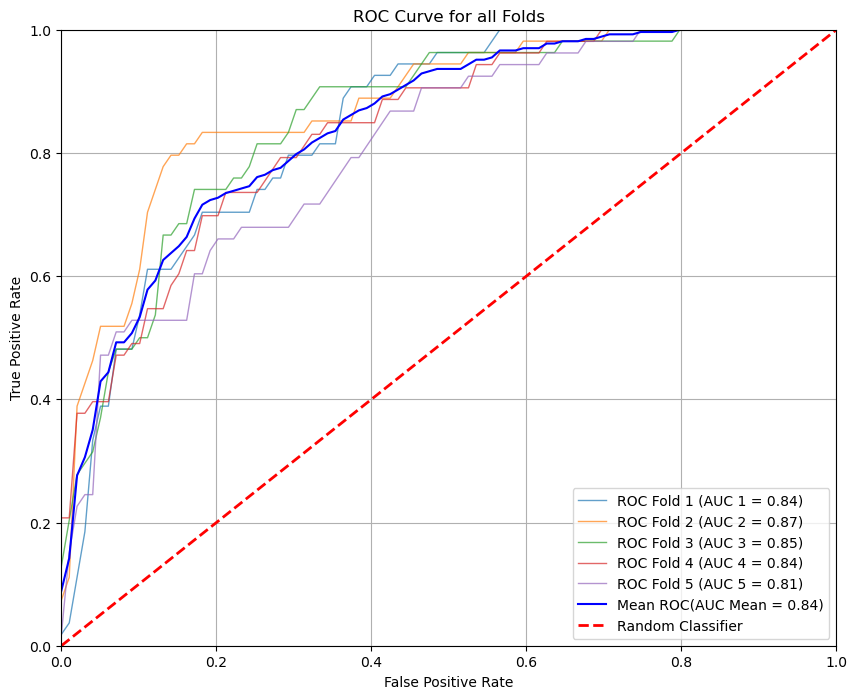

In [211]:
# ROC-Kurven aller Folds plotten
plt.figure(figsize=(10, 8))
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, lw=1, alpha=0.7, label=f"ROC Fold {i + 1} (AUC {i+1} = {auc_list[i]:.2f})")

mean_tpr = np.mean(tprs, axis=0)
std_tpr = np.std(tprs, axis=0)
mean_auc = np.mean(auc_list)
plt.plot(mean_fpr, mean_tpr, color='b', label=f"Mean ROC(AUC Mean = {mean_auc:.2f})", lw=1.5)                            # Die Mean ROC Kurve
#plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='grey', alpha=0.2, label='± 1 Std. Dev.')      #Der Std Bereich (Grau)
plt.plot([0, 1], [0, 1], linestyle='--', color='red', lw=2, label='Random Classifier')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for all Folds')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# NUR Mean ROC Kurve

In [212]:
"""
# Nur Durchschnittliche ROC-Kurve zeichnen
mean_tpr = np.mean(tprs, axis=0)
mean_auc = np.mean(auc_list)

plt.figure(figsize=(8, 6))
plt.plot(mean_fpr, mean_tpr, label=f'Mean ROC (AUC = {mean_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--',color='r', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Stratified K-Fold ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()
"""

'\n# Nur Durchschnittliche ROC-Kurve zeichnen\nmean_tpr = np.mean(tprs, axis=0)\nmean_auc = np.mean(auc_list)\n\nplt.figure(figsize=(8, 6))\nplt.plot(mean_fpr, mean_tpr, label=f\'Mean ROC (AUC = {mean_auc:.2f})\', color=\'blue\')\nplt.plot([0, 1], [0, 1], linestyle=\'--\',color=\'r\', label=\'Random Classifier\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.title(\'Stratified K-Fold ROC Curve\')\nplt.legend(loc="lower right")\nplt.grid()\nplt.show()\n'

# Feature Importance  

In [213]:
"""
# Print Feature Importance
feature_importance = pd.Series(model.coef_[0], index=X_train.columns)
print(feature_importance)
print("")
"""

#Gib die Feature Importance in Absteigender Reihenfolge zurück
feature_importance = feature_importance.sort_values(ascending=False)
print(feature_importance)


Glucose                     1.190651
BMI                         0.660006
Age                         0.543592
DiabetesPedigreeFunction    0.333375
Pregnancies                 0.170052
SkinThickness               0.127218
BloodPressure              -0.054925
Insulin                    -0.082467
dtype: float64


# Mean Confusion Matrix 

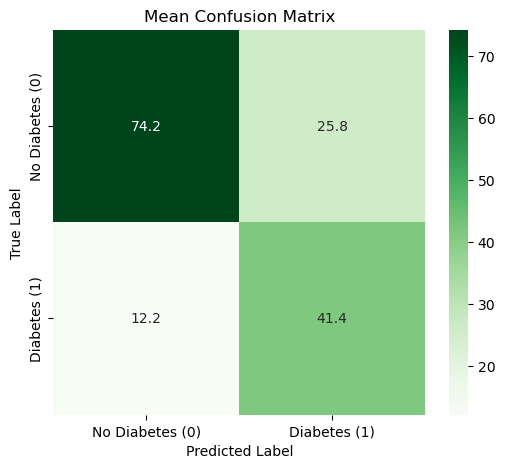

In [214]:
# Mean Confusion Matrix berechnen und plotten
mean_conf_matrix = np.mean(conf_matrices, axis=0)

plt.figure(figsize=(6, 5))
sns.heatmap(mean_conf_matrix, annot=True, fmt=".1f", cmap="Greens", 
            xticklabels=["No Diabetes (0)", "Diabetes (1)"],
            yticklabels=["No Diabetes (0)", "Diabetes (1)"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Mean Confusion Matrix')
plt.show()

# Durchschnitt und Standardabweichung der Metriken

In [215]:
# Zusammenfassung der Metriken
metrics = {
    "Precision": (np.mean(precision_list), np.std(precision_list)),
    "Recall": (np.mean(recall_list), np.std(recall_list)),
    "F1-Score": (np.mean(f1_list), np.std(f1_list)),
    "AUC": (np.mean(auc_list), np.std(auc_list))
}

print("=== Durchschnitt und Standardabweichung der Metriken ===")
for metric, (mean, std) in metrics.items():
    print(f"{metric}: Mittelwert = {mean:.3f}, Standardabweichung = {std:.3f}")
    print(f"{metric}: {mean:.3f} ± {std:.3f} ")


=== Durchschnitt und Standardabweichung der Metriken ===
Precision: Mittelwert = 0.622, Standardabweichung = 0.066
Precision: 0.622 ± 0.066 
Recall: Mittelwert = 0.772, Standardabweichung = 0.024
Recall: 0.772 ± 0.024 
F1-Score: Mittelwert = 0.687, Standardabweichung = 0.045
F1-Score: 0.687 ± 0.045 
AUC: Mittelwert = 0.843, Standardabweichung = 0.021
AUC: 0.843 ± 0.021 
